# Genetic Algorithm Example
## Problembeschreibung
Wir wollen eine Taschenlampe konzipieren.
Dafür brauchen wir eine Energiequelle, ein Lichtelement und ein Gehäuse.

In [1]:
import numpy
import math
import matplotlib.pyplot as plt
import pprint
import json
import os
import sys
from typing import List, Tuple

# Constant for elitist selection, saves the two best individuals
ELITIST = False

# Constant for fixed optimization values
FREE = False

pp = pprint.PrettyPrinter(indent=4, width=120, compact=True)


def ppdict(d: dict):
    print(json.dumps(d, sort_keys=True, indent=4))


class HiddenPrints:
    """deactivate print commands"""
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


## Encoding
Die unterschiedlichen zur Verfügung stehenden Möglichkeiten codieren wir wie folgt binär.
Der *Genotype* ist die Binärzahl und der *Phenotype* seine textuelle Entsprechung.
### Energiespeicher
 - [000] Zinc-Carbon 4,5V
 - [001] Zinc-Carbon 9V
 - [010] Alkaline 4,5V
 - [011] Alkaline 9V
 - [100] Silver-Oxide 4,5V
 - [101] Silver-Oxide 9V
 - [110] Lithium 4,5V
 - [111] Lithium 9V
### Lichtemiter
 - [000] Glühlampe 4,5V
 - [001] Glühlampe 12V
 - [010] Red LED
 - [011] Green LED
 - [100] Blue LED
 - [101] White LED
 - [110] RGB-LED
 - [111] High-Power White LED
### Gehäuse
 - [00] Vacuum Form Plastic
 - [01] 3D gedruckte Plastik
 - [10] Aluminiumguss
 - [11] gedrehter Edelstahl

Im *Individuum* oder *Chromosome* werden die drei oben eingeführten Genotypen hintereinander angefügt und sind dann drei *Gene*.

### Beispielsindividuum
[11111111] - 9V Lithiumbatterie mit High-Power White LED und Gehäuse aus gedrehtem Edelstahl

[00010001] - Zinc-Carbon 4,5V Batterie mit Blue LED und Gehäuse aus dem 3D Drucker aus Plastik

In [2]:
class WProtectedDict(dict):
    """Write Protected Dictionary"""

    keyLength = None
    __binaryAdjust = 2

    def __init__(self, mapping=(), **kwargs):
        super(WProtectedDict, self).__init__(mapping, **kwargs)

    def __setitem__(self, k, v):
        raise RuntimeError("This class is write protected")

    def __delitem__(self, v):
        raise RuntimeError("This class is write protected")

    def pop(self, k):
        raise RuntimeError("This class is write protected")

    def keylength(self):
        if self.keyLength is None:
            # this is not guarded against empty dictionaries !
            firstkey = self.keys().__iter__().__next__()
            if isinstance(firstkey, str) and str(firstkey).startswith('0b'):
                self.keyLength = len(firstkey) - self.__binaryAdjust
            else:
                self.keyLength = len(firstkey)
        return self.keyLength


In [3]:
ENERGY_DESC = WProtectedDict({
    '0b000': 'Zinc-Carbon 4,5V',
    '0b001': 'Zinc-Carbon 9V',
    '0b010': 'Alkaline 4,5V',
    '0b011': 'Alkaline 9V',
    '0b100': 'Silver-Oxide 4,5V',
    '0b101': 'Silver-Oxide 9V',
    '0b110': 'Lithium 4,5V',
    '0b111': 'Lithium 9V'              
})

LIGHT_DESC = WProtectedDict({
    '0b000': 'Light Bulb 4,5V',
    '0b001': 'Light Bulb 9V',
    '0b010': 'Red LED',
    '0b011': 'Green LED',
    '0b100': 'Blue LED',
    '0b101': 'White LED',
    '0b110': 'RGB LED',
    '0b111': 'High-Power White LED'  
})

ENCASING_DESC = WProtectedDict({
    '0b00': 'Vacuum Formed Plastic',
    '0b01': '3D Printed Plastic',
    '0b10': 'Aluminium Cast',
    '0b11': 'Machined Steel',
})


def retrieve_start_pos_in_chromosome(genotype_name: str) -> int:
    """returns the starting position of the given genotype in chromosome"""
    pos = 0
    for x in ALL:
        if x == genotype_name:
            return pos
        pos += eval(x).keylength()
    raise AttributeError("genotype_name %s not found" % genotype_name)

    
ALL = ['ENERGY_DESC', 'LIGHT_DESC', 'ENCASING_DESC']
# Output all dictionaries
for a in ALL:
    print(a)
    ppdict(eval(a))
    
# get whole chromosome length
TOTAL_BIT_LENGTH = sum(eval(x).keylength() for x in ALL)
print("Chromosome Length is: %s" % TOTAL_BIT_LENGTH)


def get_text_from_bits(bits: str) -> tuple:
    """ retrieve all phenotypes for relevant genotypes """
    # input should have total length plus the two characters for bit
    assert (len(bits) == TOTAL_BIT_LENGTH + 2)
    print("Individual: %s" % bits)

    def get_text_for_bit_pattern(genotype_name: str) -> str:
        length = eval(genotype_name).keylength()
        position = retrieve_start_pos_in_chromosome(genotype_name)
        # compensate the binary sign 0b
        start = position + 2
        # get relevant genotype
        genotype = "0b" + bits[start: start + length]
        return eval(genotype_name)[genotype]

    # Energy are the first three bits
    energy = get_text_for_bit_pattern('ENERGY_DESC')
    light = get_text_for_bit_pattern('LIGHT_DESC')
    encasing = get_text_for_bit_pattern('ENCASING_DESC')
    return energy, light, encasing
      

for bit_string in [
                    '0b00000000',
                    '0b01010010',
                    '0b10101010',
                    '0b11111111',
                  ]:
    print(get_text_from_bits(bit_string))
    print()


ENERGY_DESC
{
    "0b000": "Zinc-Carbon 4,5V",
    "0b001": "Zinc-Carbon 9V",
    "0b010": "Alkaline 4,5V",
    "0b011": "Alkaline 9V",
    "0b100": "Silver-Oxide 4,5V",
    "0b101": "Silver-Oxide 9V",
    "0b110": "Lithium 4,5V",
    "0b111": "Lithium 9V"
}
LIGHT_DESC
{
    "0b000": "Light Bulb 4,5V",
    "0b001": "Light Bulb 9V",
    "0b010": "Red LED",
    "0b011": "Green LED",
    "0b100": "Blue LED",
    "0b101": "White LED",
    "0b110": "RGB LED",
    "0b111": "High-Power White LED"
}
ENCASING_DESC
{
    "0b00": "Vacuum Formed Plastic",
    "0b01": "3D Printed Plastic",
    "0b10": "Aluminium Cast",
    "0b11": "Machined Steel"
}
Chromosome Length is: 8
Individual: 0b00000000
('Zinc-Carbon 4,5V', 'Light Bulb 4,5V', 'Vacuum Formed Plastic')

Individual: 0b01010010
('Alkaline 4,5V', 'Blue LED', 'Aluminium Cast')

Individual: 0b10101010
('Silver-Oxide 9V', 'Red LED', 'Aluminium Cast')

Individual: 0b11111111
('Lithium 9V', 'High-Power White LED', 'Machined Steel')



## Population
Eine Population mit einer festen Populationsgröße wird angelegt.

In [4]:
POPULATION_SIZE = 100


class Population:
    def __init__(self):
        self._population = {i + 1:
                       [numpy.random.randint(0, 2) for _ in range(TOTAL_BIT_LENGTH)]
                       for i in range(POPULATION_SIZE)
                       }
        
    def from_population(self, pop: List[List[int]]):
        assert len(pop) == POPULATION_SIZE
        # inpop = copy.deepcopy(pop)
        self._population = {i + 1: p for i, p in zip(range(POPULATION_SIZE), pop)}
        
    @property
    def population(self):
        return self._population
    
    def population_in_decimal(self):
        return self.__decimal_representation_with_slice(slice(len(self.population)))
    
    def energy_in_decimal(self):
        return self.__decimal_representation_with_slice(slice(3))
    
    def light_in_decimal(self):
        return self.__decimal_representation_with_slice(slice(3, 6))
    
    def encasing_in_decimal(self):
        return self.__decimal_representation_with_slice(slice(6, len(self.population)))

    def __decimal_representation_with_slice(self, slc: slice) -> list:
        return [
            self.convert_to_decimal_key(pop[slc]) for _, pop in self.population.items()
        ]
    
    def items(self) -> [tuple]:
        return self.population.items()
    
    def __getitem__(self, item):
        return self.population[item]
    
    @staticmethod
    def convert_to_decimal_key(bits: list):
        out = 0
        for bit in bits:
            out = (out << 1) | bit
        return out

    def is_single_solution(self) -> bool:
        """if there is only the same chromosome in the whole population return true"""
        # initialize compare variable
        compare: int = self.convert_to_decimal_key(self.population.values().__iter__().__next__())
        for chromosome in self.population.values():
            if compare != self.convert_to_decimal_key(chromosome):
                # we got something that is not a double
                return False
        # all entries are the same !
        return True


first_population = Population()

pp.pprint(first_population.population)


{   1: [1, 1, 0, 1, 0, 1, 0, 0],
    2: [1, 0, 0, 1, 1, 0, 1, 1],
    3: [0, 0, 1, 0, 0, 0, 0, 1],
    4: [0, 1, 0, 1, 0, 0, 1, 1],
    5: [0, 1, 1, 1, 1, 0, 1, 1],
    6: [1, 1, 1, 0, 0, 1, 0, 0],
    7: [0, 0, 1, 0, 0, 1, 1, 1],
    8: [1, 1, 1, 1, 0, 1, 0, 0],
    9: [1, 0, 0, 0, 1, 1, 1, 0],
    10: [1, 0, 0, 1, 1, 1, 1, 1],
    11: [0, 1, 0, 1, 0, 1, 1, 0],
    12: [1, 0, 1, 0, 1, 1, 0, 0],
    13: [0, 0, 1, 1, 1, 0, 1, 1],
    14: [0, 0, 1, 1, 0, 0, 0, 0],
    15: [1, 0, 0, 1, 1, 0, 0, 1],
    16: [1, 0, 1, 0, 1, 1, 0, 1],
    17: [1, 1, 0, 0, 1, 1, 0, 1],
    18: [0, 0, 1, 1, 0, 0, 1, 1],
    19: [0, 1, 1, 0, 1, 0, 0, 1],
    20: [0, 0, 1, 1, 0, 0, 1, 0],
    21: [0, 0, 1, 1, 0, 1, 1, 0],
    22: [1, 1, 0, 0, 0, 0, 0, 0],
    23: [0, 1, 0, 0, 1, 1, 1, 0],
    24: [0, 1, 0, 1, 1, 1, 0, 1],
    25: [1, 1, 1, 1, 0, 1, 1, 0],
    26: [0, 1, 0, 0, 0, 1, 0, 0],
    27: [1, 0, 1, 0, 0, 0, 1, 1],
    28: [0, 1, 0, 1, 1, 1, 0, 0],
    29: [0, 1, 0, 0, 1, 0, 0, 1],
    30: [1, 1, 0, 0, 1,

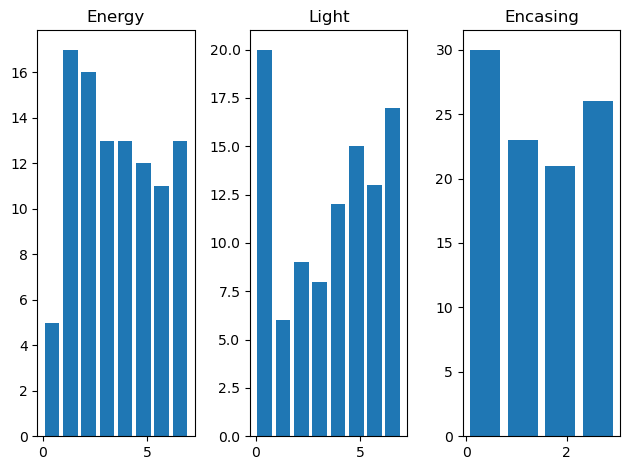

In [5]:
%matplotlib inline


def draw_genotype_histograms(data_for_one, data_for_two, data_for_three, lbl=None):
    # generate histograms of the three features
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, linewidth=1800)

    # energy storage
    ax1.hist(data_for_one, bins=8, rwidth=0.8)
    ax1.set_title('Energy')

    # luminance system
    ax2.hist(data_for_two, bins=8, rwidth=0.8)
    ax2.set_title('Light')

    # encasing
    ax3.hist(data_for_three, bins=4, rwidth=0.8, label=lbl)
    ax3.set_title('Encasing')

    fig.tight_layout()
    if lbl:
        plt.legend()
    plt.show()


draw_genotype_histograms(first_population.energy_in_decimal(),
                         first_population.light_in_decimal(),
                         first_population.encasing_in_decimal())


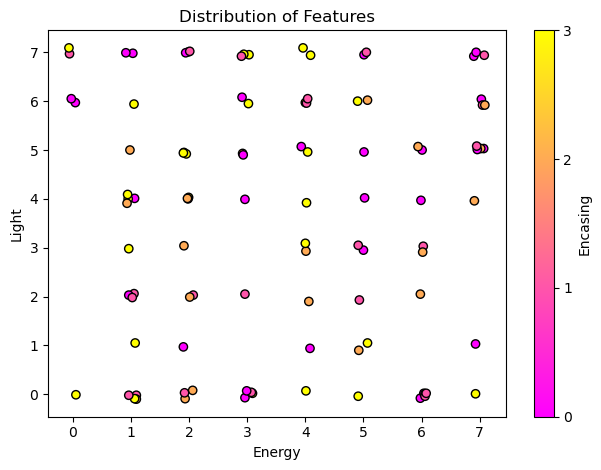

In [6]:
# generate a scatter plot to show distribution in population
fig, ax = plt.subplots()

scatter = numpy.arange(-0.1, 0.1, 0.01)
# convert first genotype to x, second to y and last one as a color code
# we use an epsilon value to scatter the values a little bit for better visibility
sc = ax.scatter(x=[
               value + numpy.random.choice(scatter) 
               for value in first_population.energy_in_decimal()
           ], 
           y=[
               value + numpy.random.choice(scatter) 
               for value in first_population.light_in_decimal()
           ],
           c=first_population.encasing_in_decimal(),
           cmap=plt.get_cmap('spring'),
           edgecolors='black')
ax.set_xlabel("Energy")
ax.set_ylabel("Light")

plt.title('Distribution of Features')
fig.tight_layout()

cbar = plt.colorbar(sc, ticks=[0, 1, 2, 3])
cbar.ax.set_ylabel('Encasing', rotation=90, va="top")

plt.show()


## Fitness Function
$Fitness = A \cdot Leuchtkraft + B \cdot Energiedichte - C \cdot Kosten + D \cdot Haltbarkeit$

Fitness soll maximiert werden!

### Parameter
- $A$ = untergeordnet
- $B$ = wichtig
- $C$ = sehr wichtig
- $D$ = fast egal

In [7]:
# store fitness data for energy (Voltage, Energy MJ/kg, Cost (1 to 10))
ENERGY = {0: [1.2,  0.13,  1],
          1: [1.15, 0.5,   3],
          2: [1.5,  0.47, 10],
          3: [3.0,  1.00,  8]}
# voltage dict
VOLTAGE = {0: 4.5, 
           1: 9}

if not FREE:
    # initialize the random number generator with a fixed value
    numpy.random.seed([3295990559, 1910945580, 1644057594, 1393720002, 1756792092])

# light emitter (cost (1 to 10), luminescence (1 to 10))
LIGHT = {j: [numpy.random.randint(0, 11), numpy.random.randint(0, 11)] for j in range(8)}

# encasing data (endurance value (1 to 10), cost value (1 to 10))
ENCASING = {j: [numpy.random.randint(0, 11), numpy.random.randint(0, 11)] for j in range(4)}

for x in ["ENERGY", "VOLTAGE", "LIGHT", "ENCASING"]:
    print(x)
    pp.pprint(eval(x))

# Parameter
A = 0.3
B = 0.8
C = 1
D = 0.1

if not FREE:
    # set random number generator free
    numpy.random.seed()


ENERGY
{0: [1.2, 0.13, 1], 1: [1.15, 0.5, 3], 2: [1.5, 0.47, 10], 3: [3.0, 1.0, 8]}
VOLTAGE
{0: 4.5, 1: 9}
LIGHT
{0: [2, 9], 1: [3, 6], 2: [6, 7], 3: [9, 3], 4: [4, 2], 5: [1, 6], 6: [5, 4], 7: [3, 2]}
ENCASING
{0: [3, 5], 1: [3, 2], 2: [1, 0], 3: [2, 0]}


# Fitnessfunktion
Die Fitnessfunktion enthält die Funktion gegen die optimiert werden soll. Jedes Individuum kann darauf angewendet werden und resultiert in einem Fitnesswert.

In [8]:
def fitness(individual: List[int]):
    print("input: %s" % individual)
    # split individual in parts
    energy_key, voltage_key, light_key, encasing_key = individual[0:2], individual[2:3], individual[3:6], individual[6:]
    print("energy_key:%s voltage_key:%s light_key:%s encasing_key:%s" % (
        energy_key, voltage_key, light_key, encasing_key))
    # calculate

    bat_voltage, bat_energy, bat_cost = ENERGY[Population.convert_to_decimal_key(energy_key)]
    light_cost, light_lum = LIGHT[Population.convert_to_decimal_key(light_key)]
    enc_endurance, enc_cost = ENCASING[Population.convert_to_decimal_key(encasing_key)]

    result = light_lum * A
    result += bat_energy * B
    result -= math.ceil(VOLTAGE[voltage_key[0]] / bat_voltage) * bat_cost + light_cost + enc_cost * C
    result += enc_endurance * D

    print("Result: %f" % result)
    return result


for chromosome in (
     [0, 0, 0, 0, 0, 0, 0, 0],
     [0, 1, 0, 1, 1, 0, 1, 1],
     [1, 1, 1, 1, 1, 1, 1, 1]
):
    fitness(chromosome)
    print()


input: [0, 0, 0, 0, 0, 0, 0, 0]
energy_key:[0, 0] voltage_key:[0] light_key:[0, 0, 0] encasing_key:[0, 0]
Result: -7.896000

input: [0, 1, 0, 1, 1, 0, 1, 1]
energy_key:[0, 1] voltage_key:[0] light_key:[1, 1, 0] encasing_key:[1, 1]
Result: -15.200000

input: [1, 1, 1, 1, 1, 1, 1, 1]
energy_key:[1, 1] voltage_key:[1] light_key:[1, 1, 1] encasing_key:[1, 1]
Result: -25.400000



# Selection und Cross Over
## Selection
Für die *Cross Over* Operation brauchen wir zwei Eltern Chromosome.
Diese werden mittels der *Selection* ausgewählt.

### Roulette Wheel Selection
(fitness proportional selection)

Jedes Individuum bekommt einen *"Slot"* auf einem Rouletterad zugewiesen, dessen breite proportional zu seiner Fitness ist.

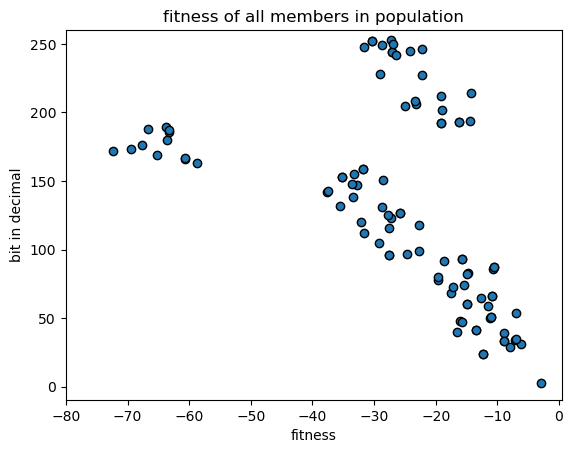

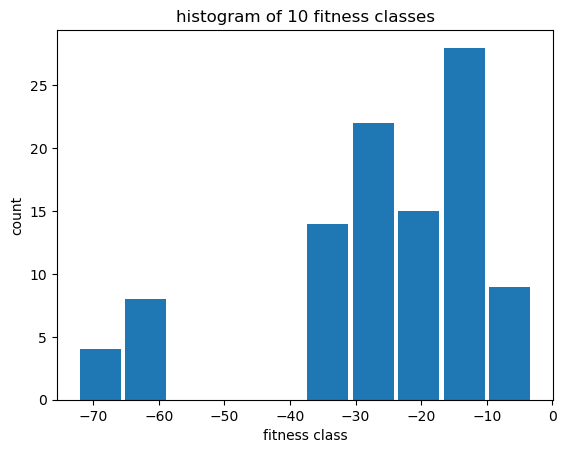

In [9]:
# fitness allocation
from typing import ValuesView


def allocate_fitness(population: Population):
    return {k: fitness(pop) for k, pop in population.items()}


# fitness allocation, we pipe output to null
with HiddenPrints():
    first_pop_fitness = allocate_fitness(first_population)


def plot_value_against_decimal(pop_set_one: Tuple[Population, ValuesView],
                               pop_set_two: Tuple[Population, ValuesView] = None,
                               xlabel: str = "fitness",
                               title: str = "fitness of all members in population",
                               labels: Tuple[str, str] = ("1.", None),
                               markers: Tuple[str, str] = ('o', '^')):
    assert len(pop_set_one) == 2
    plt.scatter(pop_set_one[1], pop_set_one[0].population_in_decimal(),
                marker=markers[0], label=labels[0], edgecolor="black")
    plt.xlabel(xlabel)
    plt.ylabel("bit in decimal")
    plt.title(title)

    if pop_set_two is not None:
        plt.scatter(pop_set_two[1], pop_set_two[0].population_in_decimal(),
                    edgecolor="black", marker=markers[1], label=labels[1])
        plt.legend()

    plt.ylim(top=260)
    
    if xlabel == "fitness":
        plt.xlim(left=-80)
    plt.show()

    
plot_value_against_decimal((first_population, first_pop_fitness.values()))

plt.hist(first_pop_fitness.values(), bins=10, rwidth=0.9)
plt.xlabel("fitness class")
plt.ylabel("count")
plt.title("histogram of 10 fitness classes")
plt.show()


Minimum Fitness: -72.42
Maximum Fitness: -3.00


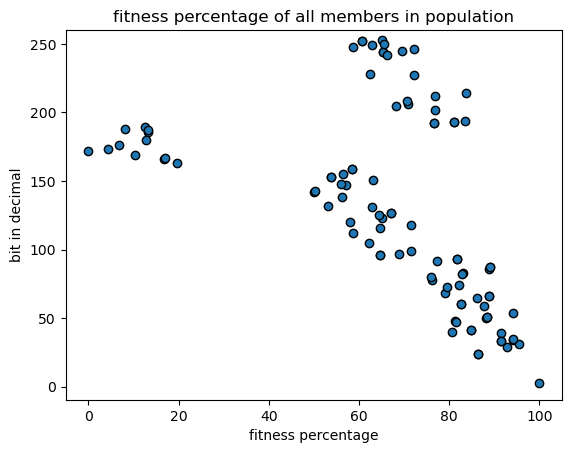

In [10]:
# calc percentage of maximum fitness in population
def fitness_to_percentage(fitness):
    mif = min(fitness.values())
    print("Minimum Fitness: %.2f" % mif)
    maf = max(fitness.values())
    print("Maximum Fitness: %.2f" % maf)

    def calc_percentage(minimum_fitness, maximum_fitness, individual_fitness):
        assert minimum_fitness != maximum_fitness
        return 100 * (individual_fitness - minimum_fitness) / (maximum_fitness - minimum_fitness)

    # create the fitness percentage in relation to min and max of all fitness values
    return {k: calc_percentage(mif, maf, v) for k, v in fitness.items()}


first_pop_percentage = fitness_to_percentage(first_pop_fitness)

plot_value_against_decimal((first_population, first_pop_percentage.values()),
                           xlabel="fitness percentage",
                           title="fitness percentage of all members in population")


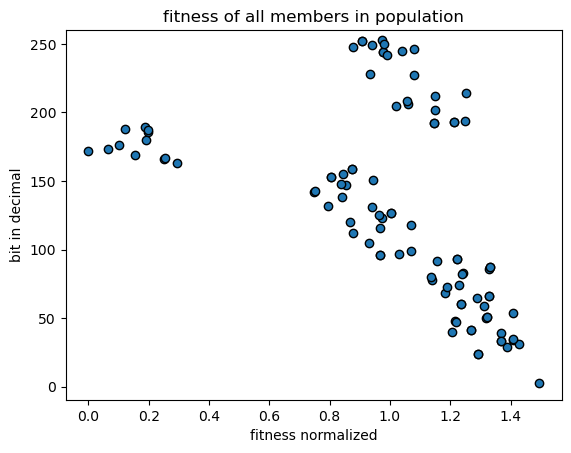

In [11]:
# normalize - fit values on roulette wheel
def normalize(percentage):
    norm_factor = sum(percentage.values())

    return {k: v / norm_factor * 100 for k, v in percentage.items()}


first_pop_normalization = normalize(first_pop_percentage)
plot_value_against_decimal((first_population, first_pop_normalization.values()),
                           xlabel="fitness normalized",
                           title="fitness of all members in population")


First Element: [id: 12; value: 0.0]
Last Element: [id: 61; value: 1.495652293801707]
quintile slot sizes:
[11.915670613538852, 24.152410562026436, 29.20774461286844, 33.22852191776454]



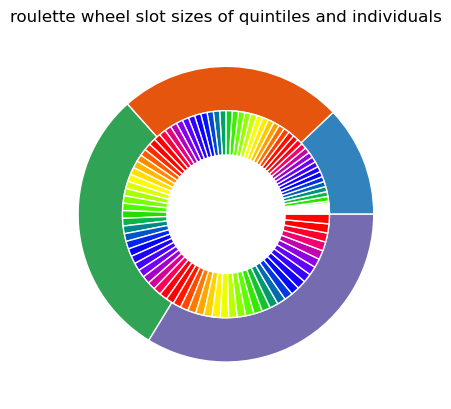

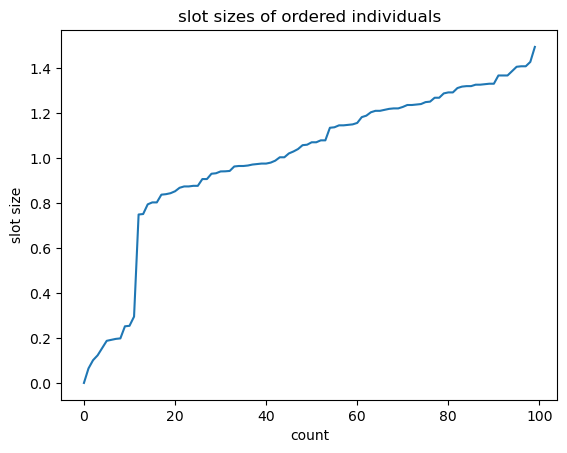

In [12]:
# sort
def sort_norms(normalization: dict) -> list:
    sorted_norms = list(normalization.items())
    sorted_norms.sort(key=lambda x: x[1])
    return sorted_norms


first_pop_sortednorms = sort_norms(first_pop_normalization)

# noinspection PyStringFormat
print("First Element: [id: %s; value: %s]" % first_pop_sortednorms[0])
# noinspection PyStringFormat
print("Last Element: [id: %s; value: %s]" % first_pop_sortednorms[-1])


def plot_dual_pie(data: list, title: str = "", *percentages: float):
    def create_quintiles():
        quintiles = []
        counter = 0
        for i, norm in zip(range(POPULATION_SIZE), data):
            if (i + 1) % 25 == 0:
                quintiles.append(counter)
                counter = 0
            counter += norm

        print("quintile slot sizes:")
        print(quintiles)
        print()
        return quintiles
    
    fig, ax = plt.subplots()
    size = 0.3
    marker_size = 0.1

    outer_colors = plt.get_cmap("tab20c")(numpy.arange(4) * 4)
    inner_colors = plt.get_cmap("prism")(numpy.arange(100))
    percent_colors = plt.get_cmap("Set1")(numpy.array([3, 999]))

    wedgeprops = dict(width=size, edgecolor='w')
    marker_wedgeprops = dict(width=marker_size, edgecolor='w')

    ax.pie(create_quintiles(), radius=1, colors=outer_colors,
           wedgeprops=wedgeprops)
    ax.pie(data, radius=1 - size, colors=inner_colors,
           wedgeprops=wedgeprops)
    ax.set(aspect="equal", title=title)
    
    if percentages is not None and len(percentages) != 0:
        radius = 1 + marker_size
        for percentage in percentages:
            ax.pie([percentage, 100 - percentage], radius=radius, colors=percent_colors, 
                   wedgeprops=marker_wedgeprops)
            radius += marker_size
    plt.show()


plot_dual_pie(data=[y for _, y in first_pop_sortednorms],
              title="roulette wheel slot sizes of quintiles and individuals")

plt.plot([y for _, y in first_pop_sortednorms])
plt.xlabel("count")
plt.ylabel("slot size")
plt.title("slot sizes of ordered individuals")
plt.show()


Random choice One: 97.04%
Random choice Two: 48.79%


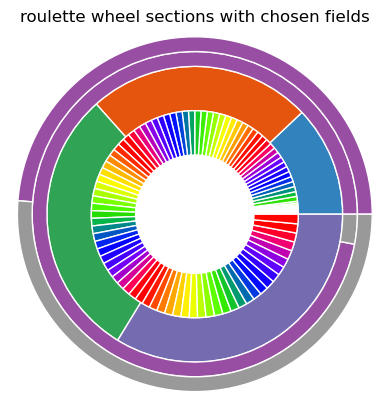

In [14]:
def select(normalized: list) -> Tuple[int, float]:
    assert len(normalized) != 0
    slot_percentage = numpy.random.random() * 100
    print("Random: %.2f %s" % (slot_percentage, '%'))
    akkumulator = 0.
    # iterate over all roulette slots
    for idValue, normValue in normalized:
        # x is the id, y is the individual weight
        if akkumulator < slot_percentage <= (akkumulator + normValue):
            print("Found it! id(%03d): %0.4f [%8.4f %s]" % (idValue, normValue, akkumulator, '%'))
            return idValue, slot_percentage
        else:
            print("Nope      id(%03d): %0.4f [%8.4f %s]" % (idValue, normValue, akkumulator, '%'))
            akkumulator += normValue


with HiddenPrints():
    id_one, choice_one = select(first_pop_sortednorms)
    id_two, choice_two = select(first_pop_sortednorms)
    
for nr, choice in zip(("One", "Two"), (choice_one, choice_two)):
    print("Random choice %s: %.2f%s" % (nr, choice, '%'))
with HiddenPrints():
    plot_dual_pie([y for _, y in first_pop_sortednorms], 
                  "roulette wheel sections with chosen fields",
                  choice_one, choice_two)


## Cross Over
Um nun eine Vermehrung zu etablieren wählen wir einen *Cross Over* Point und tausche alle bits dahinter mit dem anderen Elternteil aus.

In [15]:
def crossover(parent_1: List[int], parent_2: List[int]) -> Tuple[List[int], List[int]]:
    print("Input Parents:\n%s\n%s\n" % (parent_1, parent_2))

    def split_list(to_split: list, crossover_point: int) -> (list, list):
        return to_split[:crossover_point], to_split[crossover_point:]

    random_crossover_point = numpy.random.randint(1, TOTAL_BIT_LENGTH)
    print("Crossover Point at: %d (starts at 0!)" % random_crossover_point)

    p1_before, p1_after = split_list(parent_1, random_crossover_point)
    print("Parent 1 split: %s and %s" % (p1_before, p1_after))
    p2_before, p2_after = split_list(parent_2, random_crossover_point)
    print("Parent 2 split: %s and %s" % (p2_before, p2_after))

    return p1_before + p2_after, p2_before + p1_after


parent1 = first_population[id_one]
parent2 = first_population[id_two]
print()
children = crossover(parent1, parent2)

print("\nResult Children:")
for child in children:
    pp.pprint(child)



Input Parents:
[0, 0, 1, 0, 0, 0, 1, 1]
[0, 1, 0, 1, 1, 1, 0, 0]

Crossover Point at: 2 (starts at 0!)
Parent 1 split: [0, 0] and [1, 0, 0, 0, 1, 1]
Parent 2 split: [0, 1] and [0, 1, 1, 1, 0, 0]

Result Children:
[0, 0, 0, 1, 1, 1, 0, 0]
[0, 1, 1, 0, 0, 0, 1, 1]


## Selection und Cross Over - Zusammengebaut
Die *Selection* wählt die *Chromosome* für das *Cross Over* aus.

Population evolved


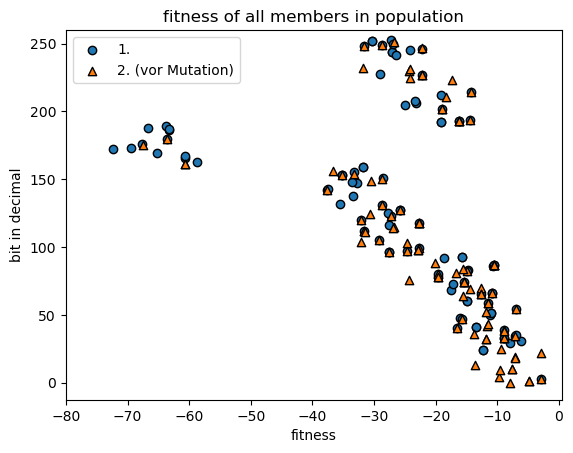

In [16]:
def evolve(population: Population) -> List[List[int]]:
    with HiddenPrints():
        fitness = allocate_fitness(population)
        percentage = fitness_to_percentage(fitness)
        normalization = normalize(percentage)
        sorted_normalization = sort_norms(normalization)
    
    new_pop = []
    
    if ELITIST:
        for eliteId, _ in sorted_normalization[-2:]:
            new_pop.append(population[eliteId])
    
    while len(new_pop) < POPULATION_SIZE:
        with HiddenPrints():
            id1, _ = select(sorted_normalization)
            id2, _ = select(sorted_normalization)
        parent1 = population[id1]
        parent2 = population[id2]
        
        with HiddenPrints():
            for child in crossover(parent1, parent2):
                new_pop.append(child)
                
    return new_pop


new_population = Population()
new_population.from_population(evolve(first_population))
print("Population evolved")

with HiddenPrints():
    second_pop_fitness_before_mutation = allocate_fitness(new_population)
    
plot_value_against_decimal((first_population, first_pop_fitness.values()),
                           (new_population, second_pop_fitness_before_mutation.values()),
                           labels=("1.", "2. (vor Mutation)"))


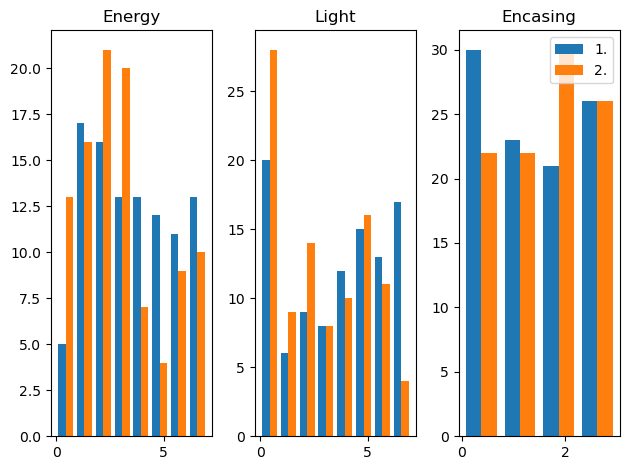

In [17]:
%matplotlib inline

draw_genotype_histograms((first_population.energy_in_decimal(), new_population.energy_in_decimal()),
                         (first_population.light_in_decimal(), new_population.light_in_decimal()),
                         (first_population.encasing_in_decimal(), new_population.encasing_in_decimal()),
                         lbl=("1.", "2."))


## Mutation
Bei der *Mutations* Operation hat jedes Bit in jedem Kind eine Chance mutiert (fliped) zu werden.
$0\rightarrow1$ und entsprechend $1\rightarrow0$

In [18]:
MUTATION_RATE = 0.3  # 30 percent

individual = [0, 0, 0, 0, 0, 0, 0, 0]

print("\tInput is\t%s\n" % individual)


def mutate(indiv: List[int]):
    """ Mutates one individual in place. MUTATION_RATE is set in global constant."""
    for i in range(len(indiv)):
        # for each bit
        rnd = numpy.random.random()
        print("Position %d: Rnd = %.3f" % (i, rnd))

        # we do mutation
        if rnd <= MUTATION_RATE:
            # flip bit
            indiv[i] = int(not indiv[i])
            print("\tMutated!\t%s" % indiv)
            
            
mutate(individual)
print("\n\tResult is\t%s" % individual)


	Input is	[0, 0, 0, 0, 0, 0, 0, 0]

Position 0: Rnd = 0.757
Position 1: Rnd = 0.171
	Mutated!	[0, 1, 0, 0, 0, 0, 0, 0]
Position 2: Rnd = 0.745
Position 3: Rnd = 0.128
	Mutated!	[0, 1, 0, 1, 0, 0, 0, 0]
Position 4: Rnd = 0.425
Position 5: Rnd = 0.256
	Mutated!	[0, 1, 0, 1, 0, 1, 0, 0]
Position 6: Rnd = 0.549
Position 7: Rnd = 0.450

	Result is	[0, 1, 0, 1, 0, 1, 0, 0]


## Mutationsrate
Die Mutationsrate ist eine wichtige Konstante für den Algorithmus!
Das richtige Maß muss gefunden werden, da einige zu niedrige Rate nicht den Ausbruch aus lokalen Optima ermöglicht, aber eine zu hohe Rate gute Lösungen vernichtet.

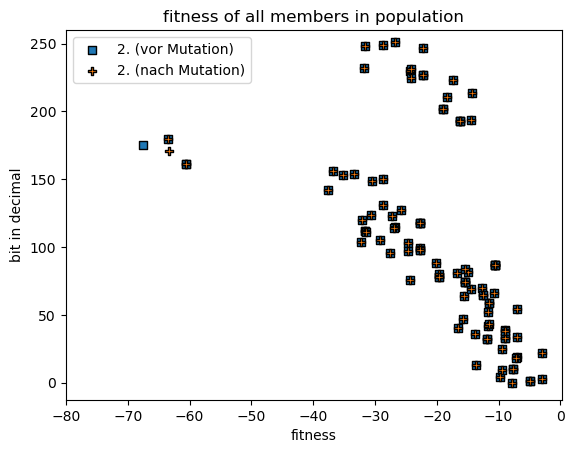

Mutation done


In [19]:
import copy

# konvergiert nach ca. 50 generationen bei FREE=False
MUTATION_RATE = 0.002  # 0.2 percent; 0.998^8 ~ 0.9841 => 1.59 %
# ca. 100
#MUTATION_RATE = 0.01 # 1 percent; 0.99^8 ~0.9227 => 7.72 %
#MUTATION_RATE= 0.3

def mutate_population(pop: Population):
    """ Mutate all members of the population."""
    for idnr, individual in pop.items():
        with HiddenPrints():
            mutate(individual)


copy_of_new_population_before_mutation = copy.deepcopy(new_population)
    
mutate_population(new_population)
print("Mutation done")

with HiddenPrints():
    new_pop_fitness = allocate_fitness(new_population)

with HiddenPrints():
    plot_value_against_decimal((copy_of_new_population_before_mutation, 
                                second_pop_fitness_before_mutation.values()),
                               (new_population, new_pop_fitness.values()),
                               labels=("2. (vor Mutation)", "2. (nach Mutation)"),
                               markers=('s', 'P'))


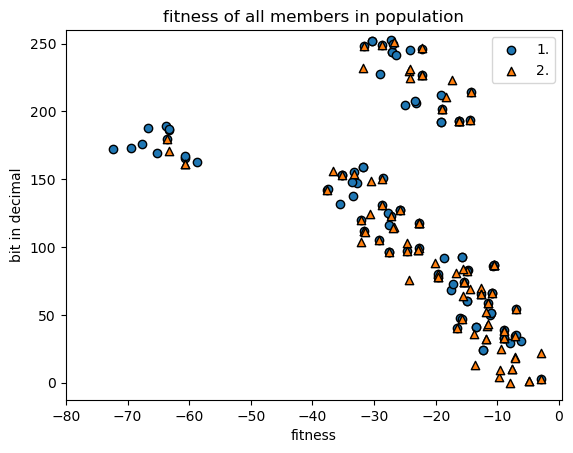

In [20]:
plot_value_against_decimal((first_population, first_pop_fitness.values()),
                           (new_population, new_pop_fitness.values()),
                           labels=("1.", "2."))


## Generationen
Diese Operationen müssen nun noch für einige Generationen durchgeführt werden.
Typische Abbruchbedingung sind eine vorbestimmte Iterationsgrenze, ein festgelegter Fitnesswert oder ähnliches.

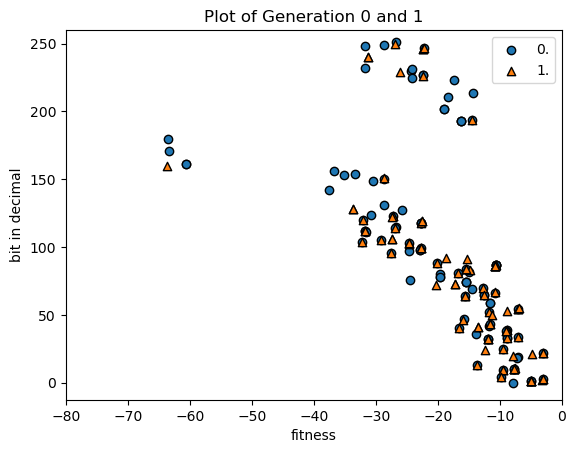

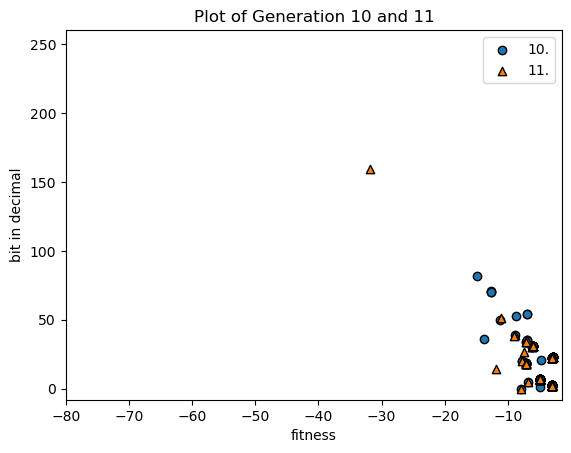

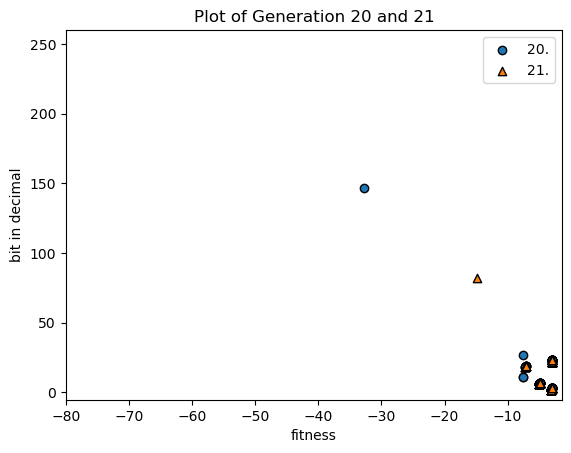

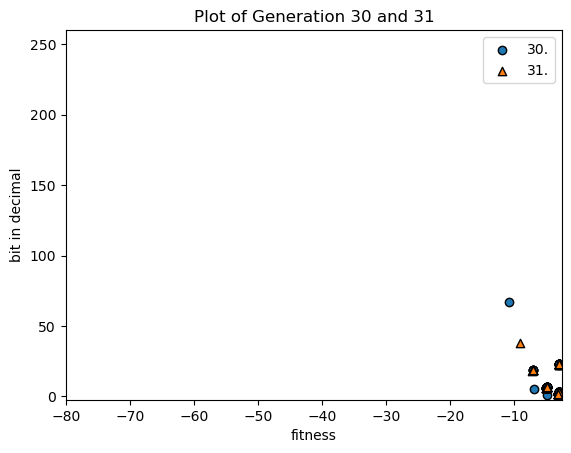

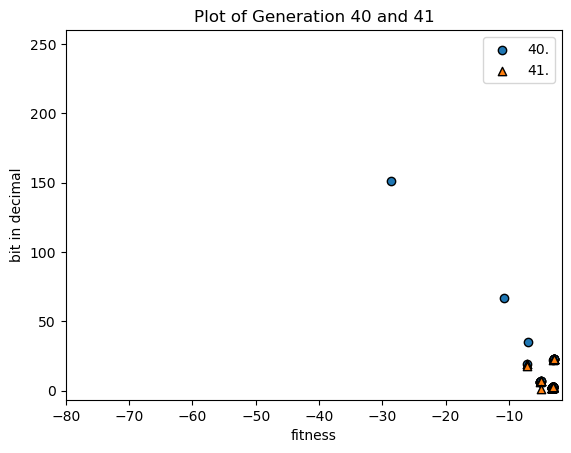

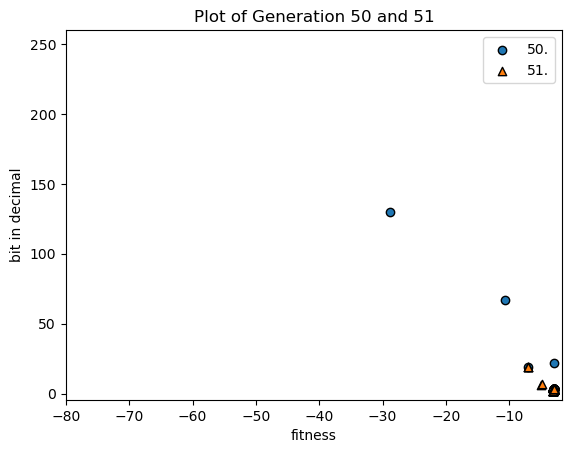

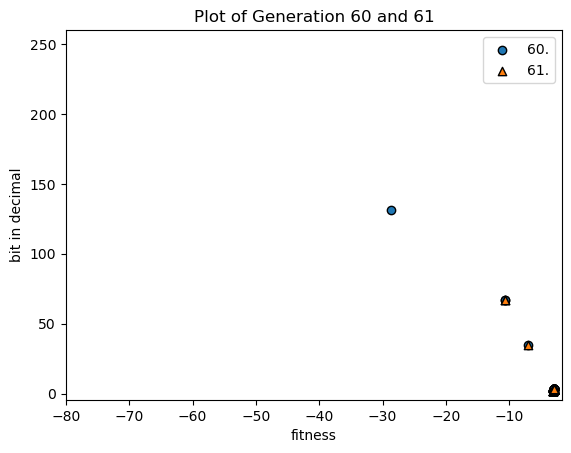

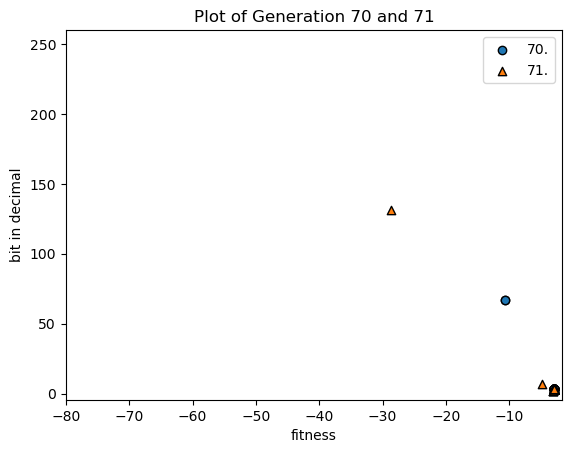

We break early, whole population is only one solution!
All done! Worked for 79 Generations


In [21]:
GENERATIONS = 100


def genetic_algorithm(start_population: Population) -> Tuple[Population, int]:
    assert start_population is not None

    # make a copy to work on
    work_population = copy.deepcopy(start_population)
    
    # this is the main loop
    i: int
    isBreak: bool = False
    for i in range(GENERATIONS):
        if work_population.is_single_solution():
            print("We break early, whole population is only one solution!")
            isBreak = True
            break
            
        next_population = Population()
        next_population.from_population(evolve(work_population))
        
        mutate_population(next_population)

        if i % (GENERATIONS/10) == 0:
            # plot plots
            with HiddenPrints():
                plot_value_against_decimal((work_population, 
                                            allocate_fitness(work_population).values()),
                                           (next_population, 
                                            allocate_fitness(next_population).values()),
                                           title="Plot of Generation %d and %d" % (i, i+1),
                                           labels=("%d." % i, "%d." % (i+1)))

        # set it back to work population
        work_population = next_population
        
    # return the last population and the count of used Generations
    if isBreak:
        generation = i-1
    else:
        generation = i
        
    return work_population, generation


result_population, lived_generations = genetic_algorithm(new_population)
print("All done! Worked for %d Generations" % lived_generations)


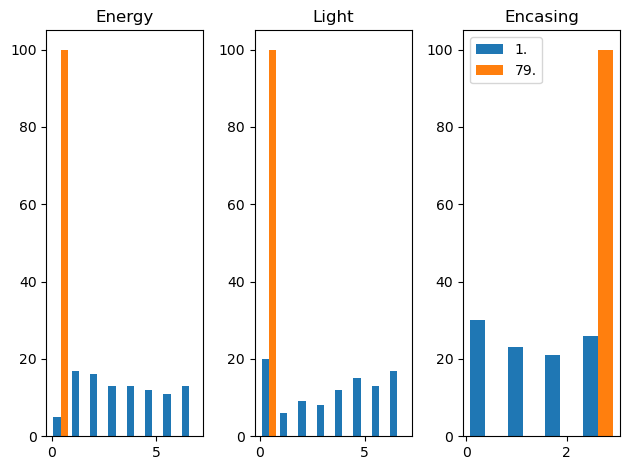

In [22]:
%matplotlib inline

draw_genotype_histograms((first_population.energy_in_decimal(), 
                          result_population.energy_in_decimal()),
                         (first_population.light_in_decimal(), 
                          result_population.light_in_decimal()),
                         (first_population.encasing_in_decimal(), 
                          result_population.encasing_in_decimal()),
                         lbl=("1.", "%d." % lived_generations))


First Population
Minimum Fitness: -72.424
Maximum Fitness: -2.996
Last Population
Minimum Fitness: -2.996
Maximum Fitness: -2.996


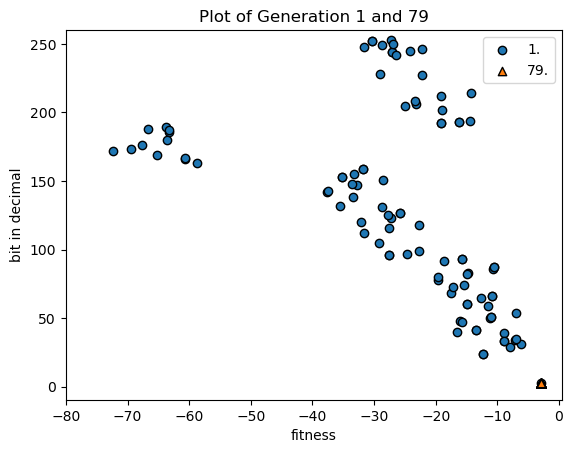

In [23]:
%matplotlib inline

with HiddenPrints():
    result_pop_fitness = allocate_fitness(result_population)
    
print("First Population")
print("Minimum Fitness: %s" % min(first_pop_fitness.values()))
print("Maximum Fitness: %s" % max(first_pop_fitness.values()))

print("Last Population")
print("Minimum Fitness: %s" % min(result_pop_fitness.values()))
print("Maximum Fitness: %s" % max(result_pop_fitness.values()))

plot_value_against_decimal((first_population,
                            first_pop_fitness.values()),
                           (result_population,
                            result_pop_fitness.values()),
                           title="Plot of Generation 1 and %d" % lived_generations,
                           labels=("1.", "%d." % lived_generations))


In [24]:
maf = max(result_pop_fitness.values())
mafId = list(result_pop_fitness.keys())[list(result_pop_fitness.values()).index(maf)]

chromosome = result_population[mafId]
print(chromosome)
print(get_text_from_bits("0b" + str(chromosome).replace('[', '').replace(']', '').replace(' ', '').replace(',', '')))


[0, 0, 0, 0, 0, 0, 1, 1]
Individual: 0b00000011
('Zinc-Carbon 4,5V', 'Light Bulb 4,5V', 'Machined Steel')
